In [126]:
#Change this to speed up reading, None to run all, this will take a long time, maybe 30 minutes but similar results is achieved with around 1000
n_of_files = 5000 #1000 or None

real_folder = "/content/drive/MyDrive/DS 3000 Project/real" #change this to the real folder path
fake_folder = "/content/drive/MyDrive/DS 3000 Project/fake" #change this to fake folder path, if a shortcut of the shared folder is added to your drive, nothing needs to be changed

In [127]:
from google.colab import drive
drive.mount('/content/drive')
#un comment if running on google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#imports

In [129]:
#loads audio files with paramters of the file path, the duration of the audio file in secconds, and the sampling rate in Hz
#files must be in the format of .wav
def load_audio_file(file_path, duration=2.0, sr=22050):
    audio_data, sr = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    return audio_data, sr

In [130]:
from tqdm import tqdm #import tqdm for loading bar

#this function loads data from folders taking in the path to the real folder, the path to the fake folder, and the sampling rate in Hz
def load_data_from_folders(real_folder, fake_folder, sr=22050):
    real_data = []
    fake_data = []
    labels = []
    #variables to store data

    # Load real data
    print("Loading Real Folder")
    for file_name in tqdm(os.listdir(real_folder)[:n_of_files]):
        if file_name.endswith('.wav'):
            audio_data, _ = load_audio_file(os.path.join(real_folder, file_name), sr=sr)
            if len(audio_data) >= 22050*2: #this checks if the length of the audio file is less than 2 seconds, only if it's larger should you append
              real_data.append(audio_data[:22050*2])
              labels.append(1)  # Label 1 for real voices
    print("Done")

    # Load fake data
    print("Loading Fake Folder")
    for file_name in tqdm(os.listdir(fake_folder)[:n_of_files]):
        if file_name.endswith('.wav'):
            audio_data, _ = load_audio_file(os.path.join(fake_folder, file_name), sr=sr)
            if len(audio_data) >= 22050*2:
              fake_data.append(audio_data[:22050*2])
              labels.append(0)  # Label 0 for fake voices
    print("Done")

    return real_data, fake_data, labels

In [131]:
#visualizes spectrograms for EDA, takes in the audio file amplitude values, and the corresponding sample rate, and the title
def visualize_waveform(audio_data, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [132]:
import random #for randomly displaying images
def visualize_audio_from_folders(real_folder, fake_folder):
    # Load and visualize real data
    real_files_all = [f for f in os.listdir(real_folder) if f.endswith('.wav')]
    real_files = random.sample(real_files_all, min(2, len(real_files_all)))

    #real_files = os.listdir(real_folder)[:2]
    for file_name in real_files:
        if file_name.endswith('.wav'):
            audio_data, sr = load_audio_file(os.path.join(real_folder, file_name))
            visualize_waveform(audio_data, sr, title=f'Real: {file_name}')


    # Load and visualize fake data

    fake_files_all = [f for f in os.listdir(fake_folder) if f.endswith('.wav')]
    fake_files = random.sample(fake_files_all, min(2, len(fake_files_all)))
    #fake_files = os.listdir(fake_folder)[:2]
    for file_name in fake_files:
        if file_name.endswith('.wav'):
            audio_data, sr = load_audio_file(os.path.join(fake_folder, file_name))
            visualize_waveform(audio_data, sr, title=f'Fake: {file_name}')

In [133]:
#variables for storing data
real_data = []
fake_data = []
labels = []

print("Loading Audio File Folders...")
real_data,fake_data,labels=load_data_from_folders(real_folder,fake_folder) #loads and saves data to variables
print("Done Loading Audio File Folders")

Loading Audio File Folders...
Loading Real Folder


100%|██████████| 5000/5000 [04:12<00:00, 19.83it/s]


Done
Loading Fake Folder


100%|██████████| 5000/5000 [02:27<00:00, 33.90it/s] 

Done
Done Loading Audio File Folders


In [134]:
print("Surviving real data",len(real_data))#>= 2s
print("Surviving fake data",len(fake_data))

Surviving real data 3722
Surviving fake data 4190


Displaying Graphs


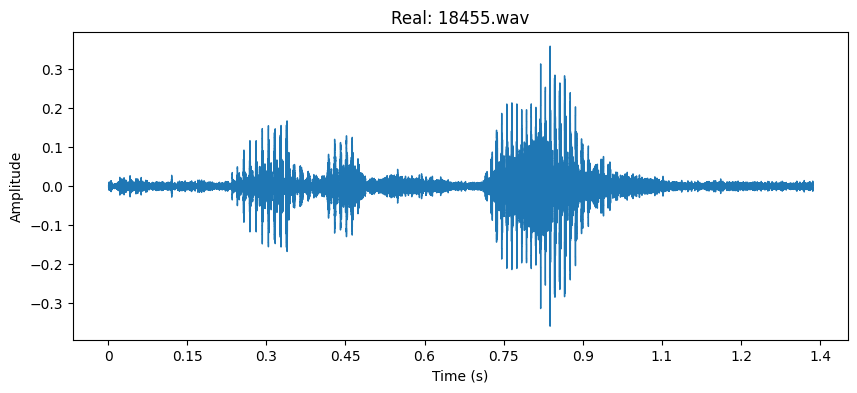

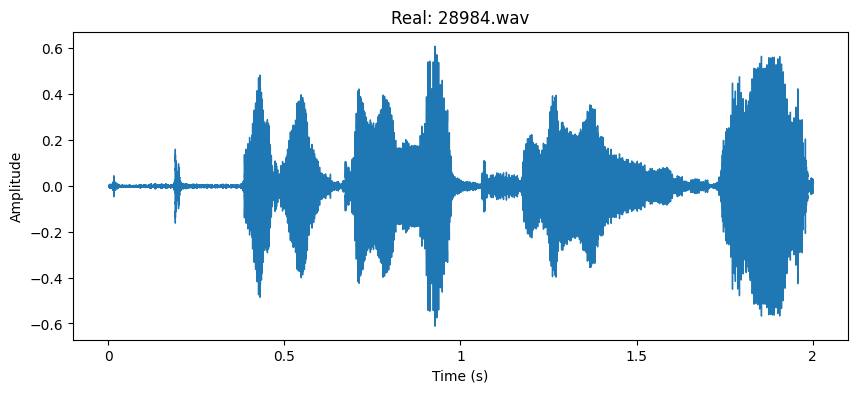

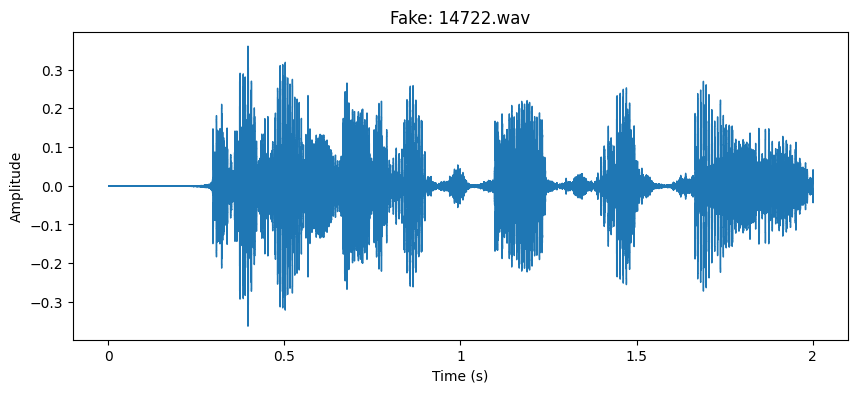

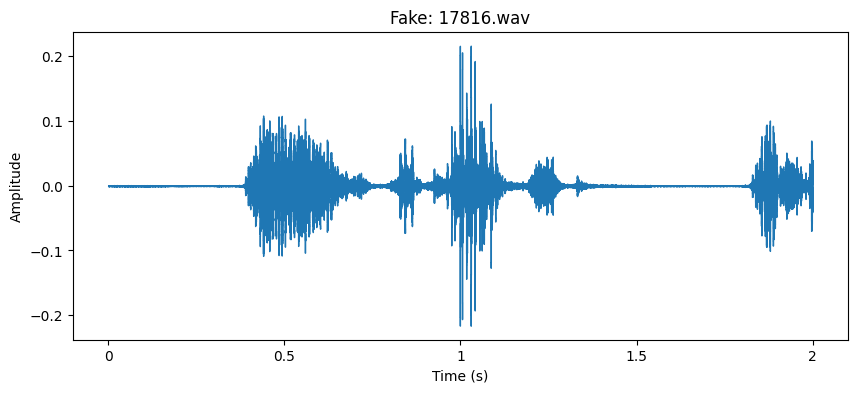

Done Displaying Graphs


In [135]:
print("Displaying Graphs")
visualize_audio_from_folders(real_folder, fake_folder)
print("Done Displaying Graphs") #displays 2 random real and fake waveforms in the form of a spectrogram

In [136]:
#extracts features for knn and svm
def extract_features(spectrogram):
    mean = np.mean(spectrogram)
    std_dev = np.std(spectrogram)
    #skewness = np.skew(spectrogram, axis=None)
    #kurtosis_val = np.kurtosis(spectrogram, axis=None)
    #return [mean, std_dev, skewness, kurtosis_val]
    return[mean,std_dev]


In [137]:
#transforms the waveform into a melspectrogram (nore in tune with what humans hear)
#takes in one waveform and sampling rate
def extract_spectrogram(audio_data, sr):
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)
    return spectrogram

In [138]:
#extracts mel spectrograms from a series of data points
#takes in a series of data
def extract_melSpectrograms(data, sr):
    spectrograms = []
    for audio in tqdm(data):
        spectrogram = extract_spectrogram(audio, sr)
        spectrograms.append(spectrogram)
    return spectrograms

In [139]:
sr = 22050
real_melSpectrograms = extract_melSpectrograms(real_data, sr)#extracts
fake_melSpectrograms = extract_melSpectrograms(fake_data, sr)

100%|██████████| 4190/4190 [00:33<00:00, 125.44it/s]


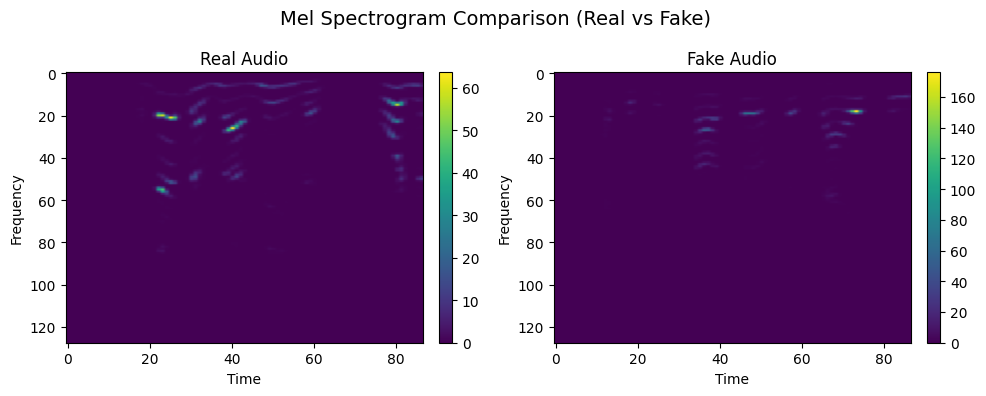

In [140]:
import matplotlib.pyplot as plt
from random import randint

plt.figure(figsize=(10, 4))

# Real
plt.subplot(1, 2, 1)
idx_real = randint(0, len(real_melSpectrograms) - 1)
plt.imshow(real_melSpectrograms[idx_real], aspect='auto', cmap='viridis')
plt.title("Real Audio")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(fraction=0.046, pad=0.04)

# Fake
plt.subplot(1, 2, 2)
idx_fake = randint(0, len(fake_melSpectrograms) - 1)
plt.imshow(fake_melSpectrograms[idx_fake], aspect='auto', cmap='viridis')
plt.title("Fake Audio")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(fraction=0.046, pad=0.04)

plt.suptitle("Mel Spectrogram Comparison (Real vs Fake)", fontsize=14)
plt.tight_layout()
plt.show()


In [141]:
x_train = real_melSpectrograms + fake_melSpectrograms #concatonate real and fake melspectrograms into xtrain
y_train = labels

In [142]:
from sklearn.model_selection import train_test_split
#split the dataset into train, test, and validation
x_train_sub, x_test, y_train_sub, y_test = train_test_split(
    x_train, y_train,
    test_size=0.10,
    random_state=42,
    stratify=y_train  # stratify on original integer labels
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_sub, y_train_sub,
    test_size=0.10,
    random_state=42,
    stratify=y_train_sub  # stratify on original integer labels
)

In [143]:
x_train = [x.reshape(128, 87, 1) for x in x_train] #reshape to add the colour channel (1) at the end, the resolution was already 128,87
x_val = [x.reshape(128, 87, 1) for x in x_val]
x_test = [x.reshape(128, 87, 1) for x in x_test]

In [144]:
#manually z normalize

#calculate mean and standard deviation
mean = np.mean(x_train)
std_dev = np.std(x_train)

#apply z normalization formula
x_train_standardized = np.array((x_train - mean) / std_dev)
x_val_standardized = np.array((x_val - mean) / std_dev)
x_test_standardized = np.array((x_test - mean) / std_dev)

#change to numpy array since keras only take numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [145]:
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import f1_score, accuracy_score
model = models.Sequential()

# First conv layer: 32 filters, 3x3, ReLU
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 87,1)))

# Second conv layer: 64 filters, 3x3, ReLU + max pooling 2x2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third conv layer: 64 filters, 3x3, ReLU + max pooling 2x2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten + Dense(64, ReLU) + output Dense(10, softmax)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile with suitable loss and optimizer
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 85, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 124, 83, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,334,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,390,593 (9.12 MB)

 Trainable params: 2,390,593 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
history = model.fit(#fit model
    x_train_standardized, y_train,
    epochs=7,
    batch_size=32,
    validation_data=(x_val_standardized, y_val),
    verbose=1
)

Epoch 1/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.6081 - auc: 0.6624 - loss: 0.6657 - precision: 0.6106 - recall: 0.5610 - val_accuracy: 0.7079 - val_auc: 0.7852 - val_loss: 0.5690 - val_precision: 0.7309 - val_recall: 0.6000
Epoch 2/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.7222 - auc: 0.7976 - loss: 0.5468 - precision: 0.7299 - recall: 0.6620 - val_accuracy: 0.7430 - val_auc: 0.8204 - val_loss: 0.5288 - val_precision: 0.7111 - val_recall: 0.7642
Epoch 3/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7818 - auc: 0.8688 - loss: 0.4528 - precision: 0.7702 - recall: 0.7699 - val_accuracy: 0.7879 - val_auc: 0.8608 - val_loss: 0.4770 - val_precision: 0.7893 - val_recall: 0.7493
Epoch 4/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8266 - auc: 0.9059 - loss: 0.3850 - precision: 0.8286 - recall: 0.7820 - val_accuracy: 0.7416 - val_auc: 0.8393 - val_loss: 0.5934 - val_precision: 0.6811 - val_recall: 0.8478
Epoch 5/7
201/201 ━━━━━━━━━━━━

In [147]:
model.evaluate(x_test_standardized, y_test) #tests data

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8164 - auc: 0.8709 - loss: 0.6411 - precision: 0.8435 - recall: 0.7473


[0.574791669845581,
 0.8207070827484131,
 0.8489425778388977,
 0.7533512115478516,
 0.8795773983001709]

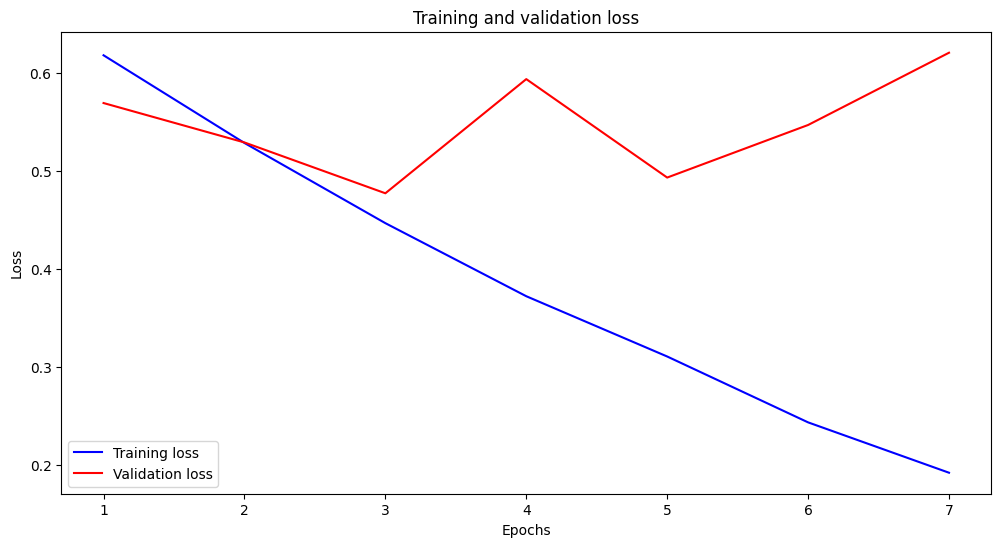

In [148]:
#Plot loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)


plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


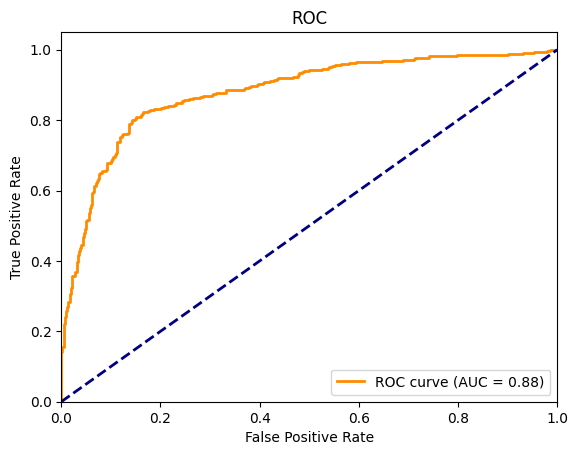

In [149]:
#ROC
y_pred = model.predict(x_test_standardized)

from sklearn.metrics import roc_curve, auc

# Flatten y_pred_probs if necessary
y_pred_probs = y_pred.ravel()  # shape (num_samples,)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute area under the curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [150]:
# Feature extraction for SVM
def extract_svm_features(audio_data):
    """
    Extract simple statistical features from audio waveform
    As mentioned in project PDF: mean, std, skewness
    """
    features = []

    # Basic statistics
    features.append(np.mean(audio_data))      # Average amplitude
    features.append(np.std(audio_data))       # Standard deviation
    features.append(skew(audio_data))         # Skewness

    features.append(kurtosis(audio_data))   # Kurtosis
    features.append(np.max(audio_data))     # Max
    features.append(np.min(audio_data))     # Min

    return np.array(features)

In [151]:
# Extract features from all loaded audio files
print("Extracting SVM features from audio data...")

X_svm = []
y_svm = []

# Extract from real audio
print(f"Processing real audio samples...")
for audio in real_data:
    features = extract_svm_features(audio)
    X_svm.append(features)
    y_svm.append(1)  # Real = 1

# Extract from fake audio
print(f"Processing {len(fake_data)} fake audio samples...")
for audio in fake_data:
    features = extract_svm_features(audio)
    X_svm.append(features)
    y_svm.append(0)  # Fake = 0

# Convert to numpy arrays
X_svm = np.array(X_svm)
y_svm = np.array(y_svm)

print(f"\nFeature extraction complete!")
print(f"Feature matrix shape: {X_svm.shape}")  # Should be (n_samples, 3)
print(f"Labels shape: {y_svm.shape}")          # Should be (n_samples,)
print(f"\nSample features (first audio):")
print(f"Mean: {X_svm[0, 0]:.6f}")
print(f"Std:  {X_svm[0, 1]:.6f}")
print(f"Skew: {X_svm[0, 2]:.6f}")

Extracting SVM features from audio data...
Processing real audio samples...
Processing 4190 fake audio samples...

Feature extraction complete!
Feature matrix shape: (7912, 6)
Labels shape: (7912,)

Sample features (first audio):
Mean: 0.000064
Std:  0.239498
Skew: 0.685298


In [152]:
# Split data into train, validation, and test sets for SVM
print("Splitting SVM data...")

# First split: 80% train+val, 20% test
X_svm_train_val, X_svm_test, y_svm_train_val, y_svm_test = train_test_split(
    X_svm, y_svm,
    test_size=0.20,
    random_state=42,
    stratify=y_svm
)

# Second split: 90% train, 10% validation (from the 80%)
X_svm_train, X_svm_val, y_svm_train, y_svm_val = train_test_split(
    X_svm_train_val, y_svm_train_val,
    test_size=0.125,  # 0.125 * 0.80 = 0.10 of total
    random_state=42,
    stratify=y_svm_train_val
)

print(f"Training set:   {X_svm_train.shape[0]} samples")
print(f"Validation set: {X_svm_val.shape[0]} samples")
print(f"Test set:       {X_svm_test.shape[0]} samples")

Splitting SVM data...
Training set:   5537 samples
Validation set: 792 samples
Test set:       1583 samples


In [153]:
# Scale features (CRITICAL for SVM!)
print("Scaling features...")

scaler = StandardScaler()

# Fit on training data only
X_svm_train_scaled = scaler.fit_transform(X_svm_train)

# Transform validation and test using training statistics
X_svm_val_scaled = scaler.transform(X_svm_val)
X_svm_test_scaled = scaler.transform(X_svm_test)

print("Scaling complete!")
print(f"\nBefore scaling (first sample):")
print(X_svm_train[0])
print(f"\nAfter scaling (first sample):")
print(X_svm_train_scaled[0])

Scaling features...
Scaling complete!

Before scaling (first sample):
[-2.7502027e-05  5.2649133e-02 -2.6350412e-01  4.6985507e+00
  2.5886020e-01 -2.5183707e-01]

After scaling (first sample):
[-0.88747966 -0.10895111 -0.93890953 -0.3802395  -0.48928398  0.3422963 ]


In [154]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score

svm_model = Pipeline([ #pipeline for svm
    ('svc',SVC(
    kernel = 'rbf',
    C=1.0,
    gamma='scale',
    probability=True,  # Enable probability estimates for ROC curve
    random_state=42,
    verbose = 1))
])
cv_Score_Svm = cross_val_score(svm_model, X_svm_train_scaled, y_svm_train, cv=5, scoring = 'f1').mean()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [155]:
print("SVM F1:",cv_Score_Svm) #Check variance

SVM F1: 0.7020613584227803


In [156]:
svm_trained = SVC(
    kernel = 'rbf',
    C=1.0,
    gamma='scale',
    probability=True,  # Enable probability estimates for ROC curve
    random_state=42,
    verbose = True)
svm_trained.fit(X_svm_train_scaled, y_svm_train)

[LibSVM]

SVC(probability=True, random_state=42, verbose=True)

In [157]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
# Evaluate SVM model
print("Evaluating SVM...")

# Predictions
y_test_pred_svm= svm_trained.predict(X_svm_test_scaled)

# Calculate metrics
test_acc = accuracy_score(y_svm_test, y_test_pred_svm)
test_precision = precision_score(y_svm_test, y_test_pred_svm)
test_recall = recall_score(y_svm_test, y_test_pred_svm)

test_f1 = f1_score(y_svm_test, y_test_pred_svm)

# Print results
print("\n" + "="*50)
print("SVM MODEL PERFORMANCE")
print("="*50)
print(f"\n{'Metric':<15} {'Test':<10}")
print("-"*50)
print(f"{'Accuracy':<15} {test_acc:<10.3f}")
print(f"{'Recall':<15} {test_recall:<10.3f}")
print(f"{'Precision':<15} {test_precision:<10.3f}")
print(f"{'F1 Score':<15} {test_f1:<10.3f}")
print("="*50)

Evaluating SVM...

SVM MODEL PERFORMANCE

Metric          Test      
--------------------------------------------------
Accuracy        0.767     
Recall          0.660     
Precision       0.809     
F1 Score        0.727     


Generating ROC curve...


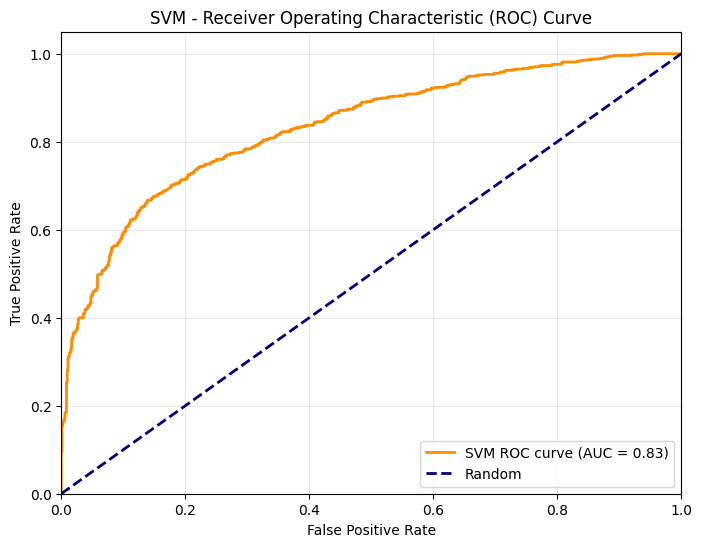

AUC Score: 0.8335


In [158]:
from sklearn.metrics import roc_curve, auc
# Plot ROC curve for SVM
print("Generating ROC curve...")

# Get probability predictions
y_test_proba = svm_trained.predict_proba(X_svm_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_svm_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'SVM ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [159]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV as GridSearch

knn_model = Pipeline([ #pipeline for knn
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
     ('scaler', StandardScaler()),
    ('knn', KNN())
     ])
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #array of k values
k_values_grid = {'knn__n_neighbors':k_values} #itterate through k values for n_neighbors
cv_Score_Knn = GridSearch(knn_model, cv=10, scoring = 'f1', param_grid= k_values_grid )
cv_Score_Knn.fit(X_svm_train_scaled, y_svm_train)

print(cv_Score_Knn.cv_results_)
print(cv_Score_Knn.best_params_)

{'mean_fit_time': array([0.00457742, 0.00496514, 0.00463457, 0.0044512 , 0.00454309,
       0.00442293, 0.00475147, 0.00446317, 0.00462058, 0.00451562]), 'std_fit_time': array([0.00050513, 0.00155735, 0.00081237, 0.00041068, 0.00032727,
       0.00014158, 0.00097458, 0.00015361, 0.00059794, 0.00014259]), 'mean_score_time': array([0.0170366 , 0.01886067, 0.01669781, 0.01692388, 0.01828792,
       0.01778264, 0.01911228, 0.01828105, 0.01774163, 0.01845949]), 'std_score_time': array([0.00109658, 0.00417075, 0.00037134, 0.00037313, 0.00089136,
       0.00079081, 0.00322255, 0.00077431, 0.00048667, 0.00069701]), 'param_knn__n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=999999), 'params': [{'knn__n_neighbors': 1}, {'knn__n_neighbors': 2}, {'knn__n_neighbors': 3}, {'knn__n_neighbors': 4}, {'knn__n_neighbors': 5}, {'knn__n_neighbors': 6}, {'knn__n_ne

In [160]:
knn_optimized = Pipeline([ #pipeline for best n_neighbor value chosen
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
     ('scaler', StandardScaler()),
    ('knn', KNN(n_neighbors= cv_Score_Knn.best_params_['knn__n_neighbors']))
     ])
knn_optimized.fit(X_svm_train_scaled, y_svm_train)



Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])

In [161]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
# Evaluate KNN model
print("Evaluating KNN...")

# Predictions
y_test_pred_knn= knn_optimized.predict(X_svm_test_scaled)

# Calculate metrics
test_acc = accuracy_score(y_svm_test, y_test_pred_knn)
test_precision = precision_score(y_svm_test, y_test_pred_knn)
test_recall = recall_score(y_svm_test, y_test_pred_knn)

test_f1 = f1_score(y_svm_test, y_test_pred_knn)

# Print results
print("\n" + "="*50)
print("KNN MODEL PERFORMANCE")
print("="*50)
print(f"\n{'Metric':<15} {'Test':<10}")
print("-"*50)
print(f"{'Accuracy':<15} {test_acc:<10.3f}")
print(f"{'Recall':<15} {test_recall:<10.3f}")
print(f"{'Precision':<15} {test_precision:<10.3f}")
print(f"{'F1 Score':<15} {test_f1:<10.3f}")
print("="*50)

Evaluating KNN...

KNN MODEL PERFORMANCE

Metric          Test      
--------------------------------------------------
Accuracy        0.743     
Recall          0.646     
Precision       0.771     
F1 Score        0.703     


Generating ROC curve...


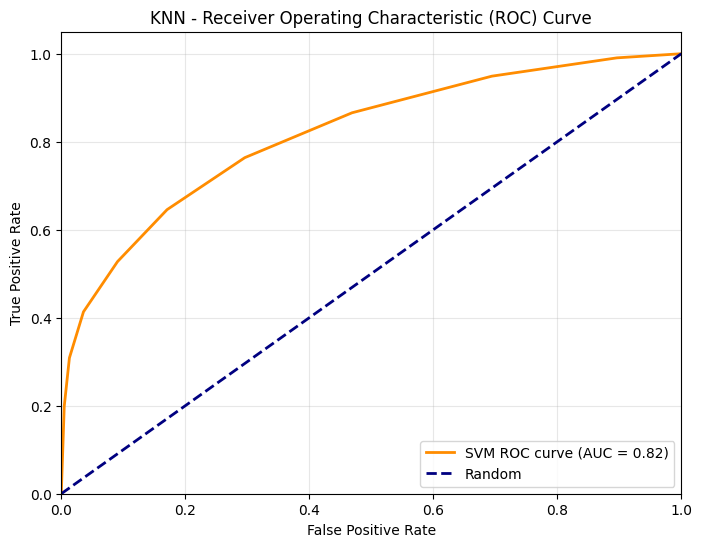

AUC Score: 0.8163


In [162]:
# Plot ROC curve for KNN
print("Generating ROC curve...")

# Get probability predictions
y_test_proba = knn_optimized.predict_proba(X_svm_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_svm_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'SVM ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")